# The goal is to predict Amazon stock price data using a univariate time series.

### Data is real-time data obtained from https://www.nasdaq.com/market-activity/stocks/amzn/historical

In [91]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib
from numpy import array
from datetime import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm
from pmdarima.arima import ndiffs


import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from keras.layers import Flatten, Dropout
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [76]:
df = pd.read_csv("Amazon.csv")

In [77]:
df['Date'].min(), df['Date'].max()

('1/10/11', '9/9/19')

In [78]:
df.columns

Index(['Date', 'Close', 'Volume', 'Open', 'High', 'Low'], dtype='object')

In [79]:
#Dropping features that are not required and summing up sales per day
cols = ['Volume', 'Open', 'High', 'Low']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Date')
df['Date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
df['Close'] = df['Close'].str.replace('$', '')
df['Close'] = df['Close'].str.replace(',', '')
df['Close'] = df['Close'].astype('float')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

In [80]:
df.head(10)

,Close
Date,
2010-07-21,117.43
2010-07-22,120.07
2010-07-23,118.87
2010-07-26,118.40
2010-07-27,117.13
2010-07-28,117.13
2010-07-29,116.86
2010-07-30,117.89
2010-08-02,120.07


In [81]:
#averaging out stock price per week. We use weekly data as each data point.
y = df['Close'].resample('W').mean()

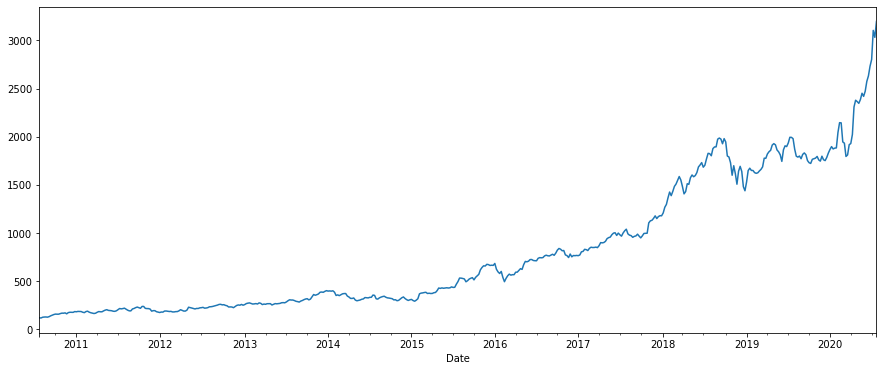

In [82]:
y.plot(figsize=(15, 6))
plt.show()

In [83]:
#splitting data from 2010-2019 for training and 2020 for testing
y_train = y[:'2019']
y_test = y['2020':]

print(len(y_train),len(y_test))

493 30


## Check for stationarity and find d value

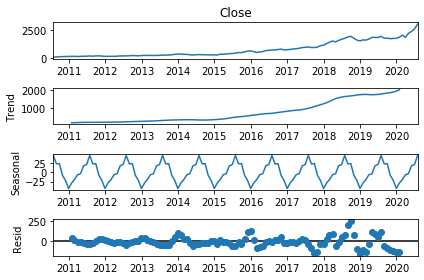

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

nresult = seasonal_decompose(y)

nresult.plot()
plt.show()

In [11]:
#p value test for entire data 2014-2017
from statsmodels.tsa.stattools import adfuller
result = adfuller(y_train)
print(result[1])

# p>0.05 This means the time series is non stationary, d=1

0.9887827134012555


In [12]:
#p value test for testing data only just to ensure statistics are maintained
result = adfuller(y_test)
print(result[1])

0.9938795082379308


### Conclusion: differencing should be required as there is a trend in the data and p value >0.05 from adf test.

## Finding p and q values

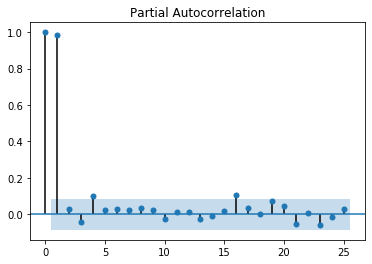

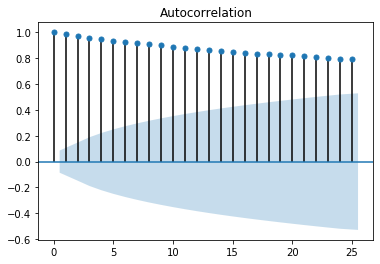

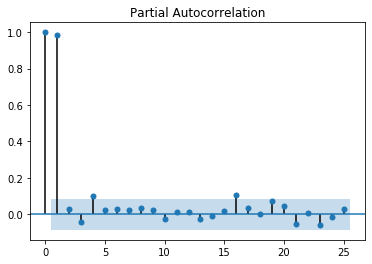

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=25)
plot_pacf(y, lags=25)

### Conclusion: p=1 and q=1

## Fitting an auto-Arima model

### Auto-arima handles finding optimal p and q values. Since ARIMA doesn't support seasonality, we use auto-arima with seasonality

In [93]:
#Finds the optimal d value which is the max value calculated from KPSS and ADF test
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [94]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)
print("Best p,d,q parameter combination:",auto.order)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=-2710.838, BIC=-2685.746, Time=0.351 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-2676.864, BIC=-2668.500, Time=0.035 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-2689.578, BIC=-2677.031, Time=0.056 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-2698.105, BIC=-2685.559, Time=0.115 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-2671.690, BIC=-2667.508, Time=0.039 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-2712.700, BIC=-2691.790, Time=0.383 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-2712.917, BIC=-2696.189, Time=0.410 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=-2712.864, BIC=-2691.954, Time=0.156 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-2713.196, BIC=-2696.468, Time=0.218 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-2712.837, BIC=-2691.927, Time=0.426 seconds
Fit ARIMA(2,1,0)

# Forecasting 2020 years results and calculating RMSE

In [95]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (fc.tolist()[0],np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

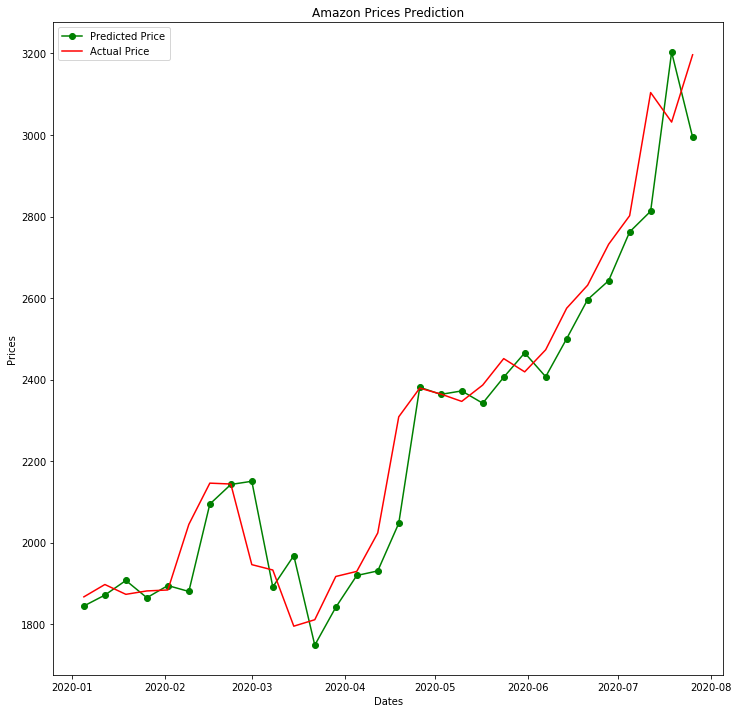

In [89]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))
axes.plot(y_test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes.plot(y_test.index, y_test, color='red', label='Actual Price')
axes.set_title('Amazon Prices Prediction')
axes.set_xlabel('Dates')
axes.set_ylabel('Prices')
axes.legend()

In [90]:
rmse = sqrt(mean_squared_error(y_test, forecasts))
print("rmse for 2020 year predictions using auto-ARIMA: ",rmse)
print(f"SMAPE: {smape(y_test, forecasts)}")

rmse for 2020 year predictions using auto-ARIMA:  111.85303252944405
SMAPE: 3.4451425318869995


# LSTM variations

### Bidirectional LSTM

In [69]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [84]:
sc = MinMaxScaler(feature_range=(0,1))
n_steps = 8 #We sample the series for every y(t-n_steps) to y(t) steps as the training data point with y(t+1) as label
y = sc.fit_transform(array(y_train).reshape(-1, 1))
X_train, y_train = split_sequence(y, n_steps)

In [85]:
n_features = 1 #because univariate time series
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], n_features)

model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=15,batch_size=32)

Epoch 1/15
485/485 [==============================] - 1s 2ms/step - loss: 0.1440
Epoch 2/15
485/485 [==============================] - 0s 233us/step - loss: 0.0280
Epoch 3/15
485/485 [==============================] - 0s 234us/step - loss: 0.0046
Epoch 4/15
485/485 [==============================] - 0s 239us/step - loss: 0.0015
Epoch 5/15
485/485 [==============================] - 0s 255us/step - loss: 0.0011
Epoch 6/15
485/485 [==============================] - 0s 256us/step - loss: 0.0010
Epoch 7/15
485/485 [==============================] - 0s 264us/step - loss: 9.4008e-04
Epoch 8/15
485/485 [==============================] - 0s 259us/step - loss: 9.4732e-04
Epoch 9/15
485/485 [==============================] - 0s 265us/step - loss: 8.8665e-04
Epoch 10/15
485/485 [==============================] - 0s 256us/step - loss: 9.1058e-04
Epoch 11/15
485/485 [==============================] - 0s 233us/step - loss: 7.9718e-04
Epoch 12/15
485/485 [==============================] - 0s 235us/ste

In [86]:
# demonstrate prediction, the problem is that if the first prediction is off then the offset for following 
# predictions increase vastely

x = list(y_train[-n_steps:])
forecast = []
for i in range(len(y_test)):
    x_input = array(x[-n_steps:])
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #After model predicts next weeks datapoint we add in the groundtruth for that week, 
    #so that we dont end up predicting over predictions and add to uncertainity.
    x.append(sc.transform(y_test[i].reshape(-1,1)))
    y_pred = sc.inverse_transform(yhat)
    forecast.append(y_pred[0][0])

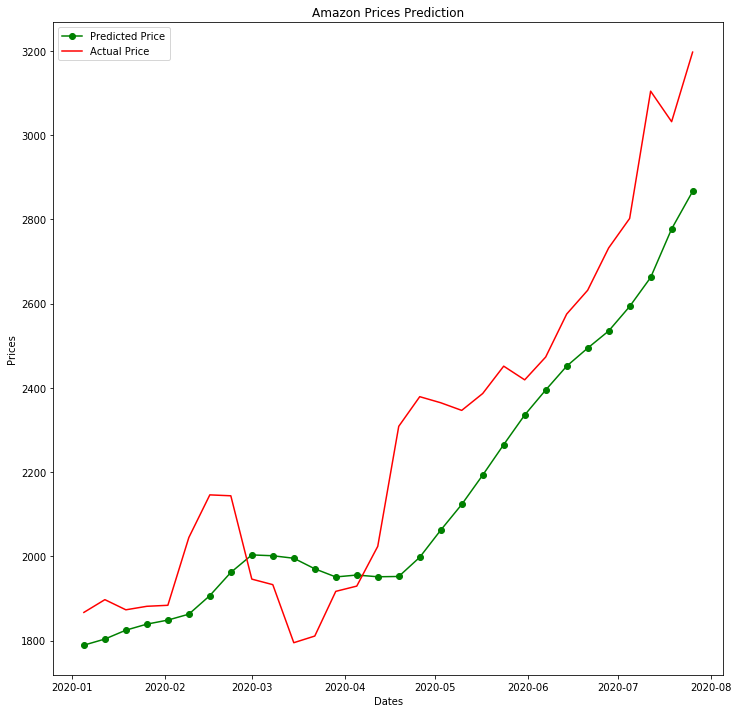

In [87]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))
axes.plot(y_test.index, forecast, color='green', marker='o',
             label='Predicted Price')

axes.plot(y_test.index, y_test, color='red', label='Actual Price')
axes.set_title('Amazon Prices Prediction')
axes.set_xlabel('Dates')
axes.set_ylabel('Prices')
axes.legend()

In [88]:
rmse = sqrt(mean_squared_error(forecast, y_test))
print("rmse for 2020 year predictions using BiLSTM: ",rmse)

rmse for 2020 year predictions using LSTM:  200.79347901581332
